In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
from tqdm.auto import tqdm

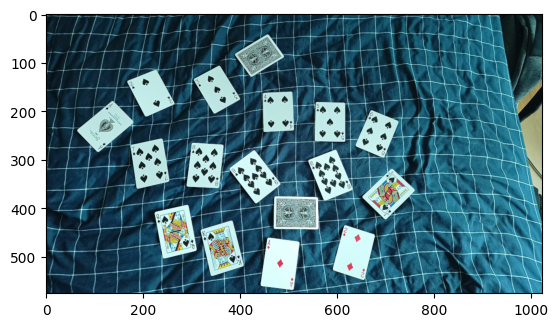

In [25]:
img = cv.imread("../assets/sample/cardset1.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

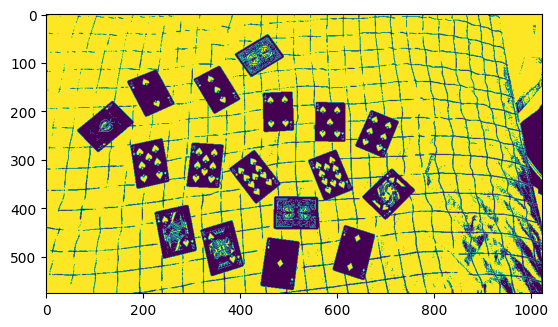

In [26]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh)

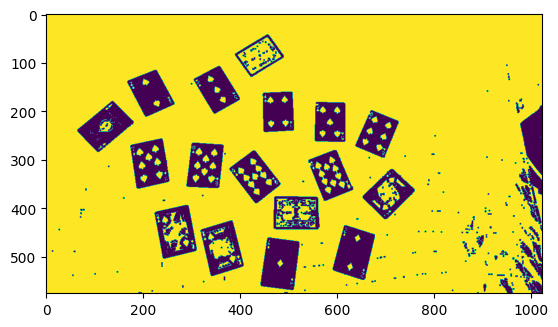

In [27]:
thresh_p = cv.morphologyEx(thresh, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8))
for i in range(10):
    thresh_p = cv.morphologyEx(thresh_p, cv.MORPH_CLOSE, np.ones((3, 3), np.uint8))
plt.imshow(thresh_p)

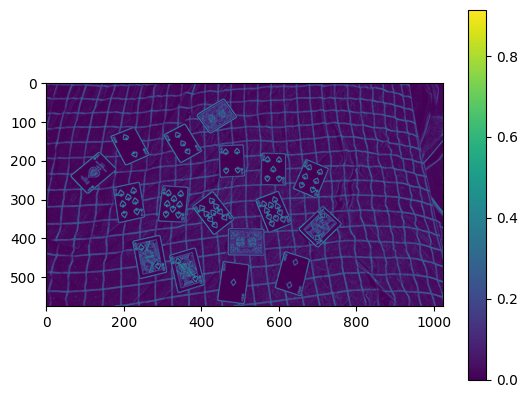

In [28]:
imgEdge = np.sum(np.abs(np.gradient(cv.cvtColor(img, cv.COLOR_RGB2GRAY))), axis=0)/255
plt.imshow(imgEdge)
plt.colorbar()

In [29]:
kimg = cv.cvtColor(img, cv.COLOR_RGB2HSV)[:, :, :2]

  0%|          | 0/50 [00:00<?, ?it/s]

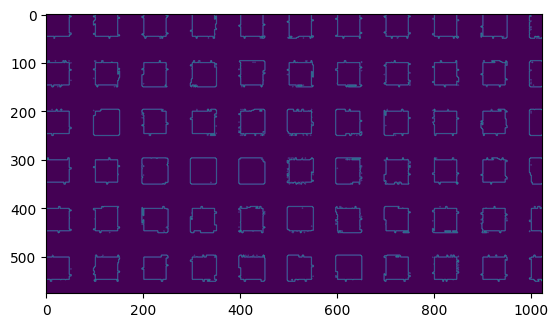

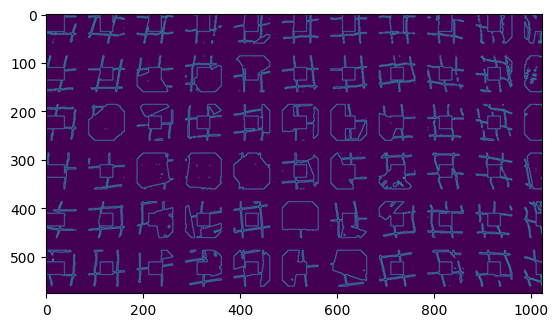

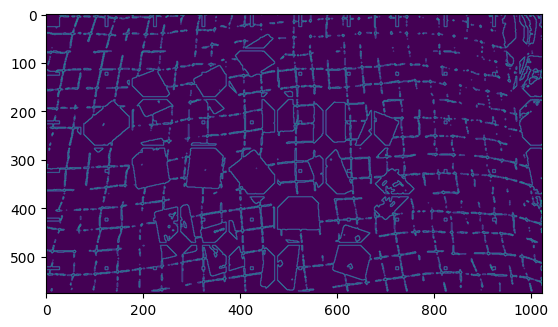

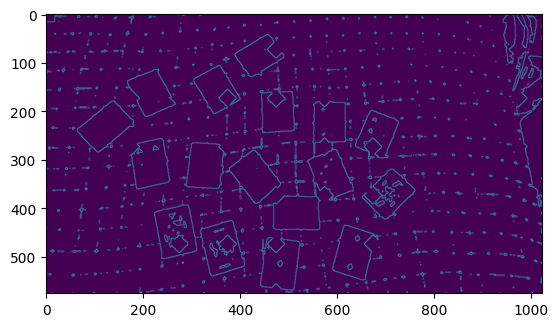

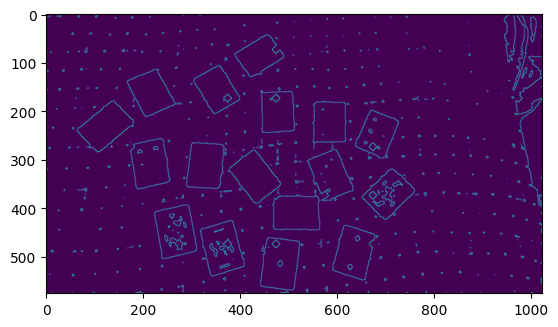

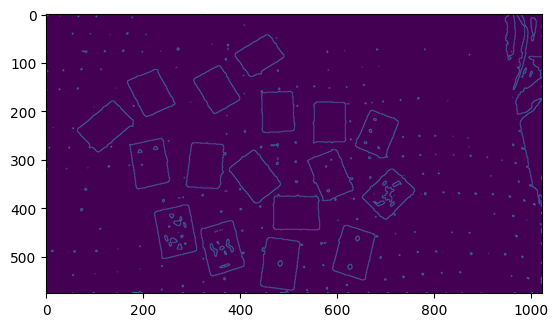

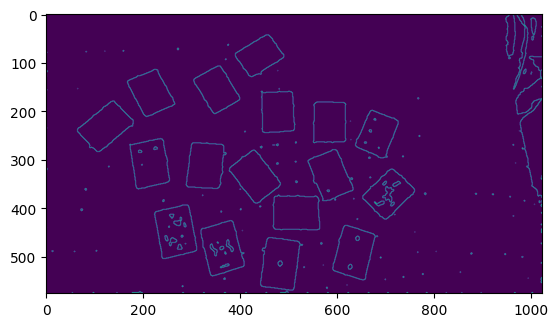

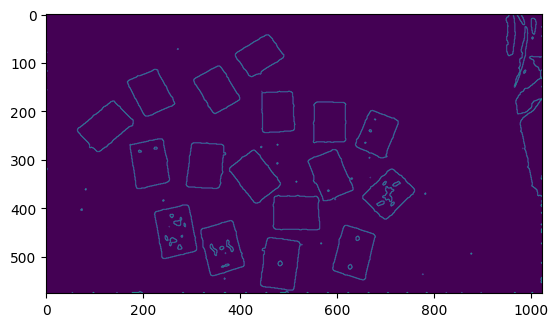

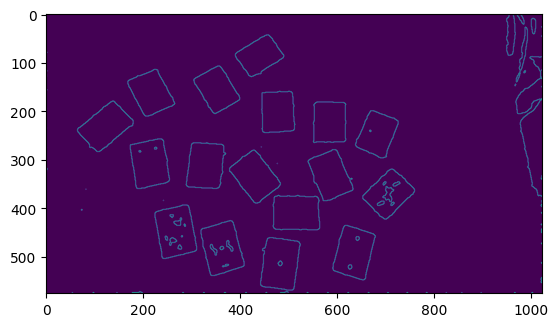

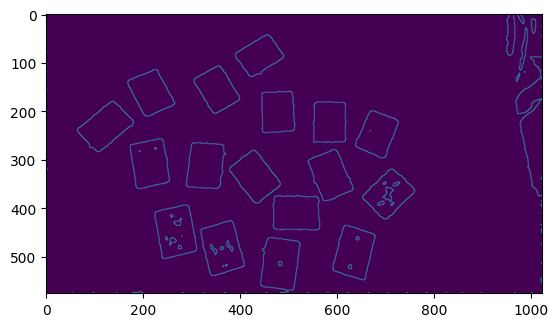

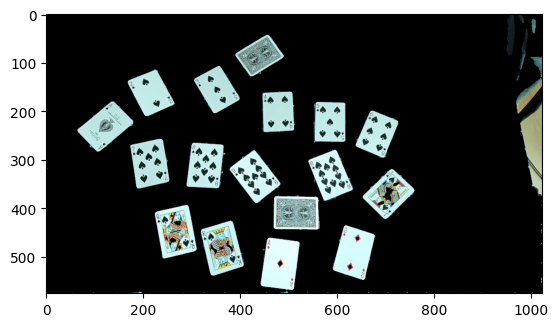

In [31]:
# levelSet = np.random.uniform(-1, 1, img.shape[:-1])


levelSet = np.zeros(img.shape[:-1]) + 0.00001
for i in range(0, levelSet.shape[0], 100):
    for j in range(0, levelSet.shape[1], 100):
        levelSet[i:i+50,j:j+50] = -0.00001

for i in tqdm(range(50)):
    bgMean = kimg[levelSet>0].mean(axis=0)
    fgMean = kimg[levelSet<0].mean(axis=0)
    
    if fgMean[1] > bgMean[1]:
        bgMean, fgMean = fgMean, bgMean
    
    levelGradY, levelGradX = np.gradient(levelSet)
    gradNorm = np.sqrt(np.square(levelGradX) + np.square(levelGradY))
    levelGradY /= (gradNorm + 0.00001)
    levelGradX /= (gradNorm + 0.00001)
    colorGrad = -np.sqrt(np.sum(np.power(np.abs(kimg - bgMean), 2), axis=2))/255 + np.sqrt(np.sum(np.power(np.abs(kimg - fgMean), 2), axis=2))/255
    
    levelSet += 1.0 * (1-imgEdge) * np.abs(levelGradX) * colorGrad
    levelSet += 1.0 * (1-imgEdge) *np.abs(levelGradY) * colorGrad
    levelDiv = (levelSet[:-2, 1:-1] + levelSet[2:, 1:-1] + levelSet[1:-1, :-2] + levelSet[1:-1, 2:] - 4*levelSet[1:-1, 1:-1])/4
    levelSet += 1.0*np.pad(levelDiv, 1)
    
    if i % 5 == 0:
        plt.figure()
        # plt.imshow(levelSet < 0)
        plt.imshow(np.sum(np.abs(np.gradient((levelSet < 0) *1.0)), 0))
        #plt.colorbar()
        # print(np.mean(np.square(img[levelSet<0] - fgMean)))
    

    

plt.figure()
plt.imshow(img * np.expand_dims(levelSet < 0, 2))

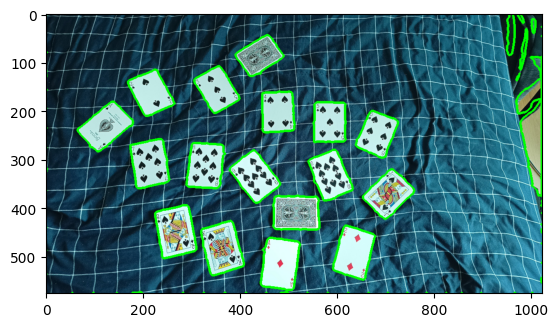

In [32]:
mask = levelSet < 0
contours, _ = cv.findContours(mask.astype('uint8'), cv.RETR_EXTERNAL , cv.CHAIN_APPROX_SIMPLE)

cimg = img.copy()
cv.drawContours(cimg, contours, -1, (0,255,0), 3)
plt.imshow(cimg)

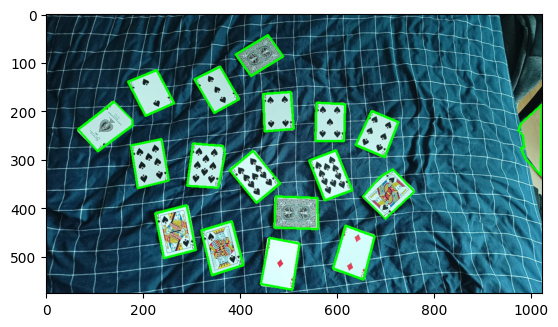

In [191]:
valid_contours = [cv.approxPolyDP(c, 5, True) for c in contours if cv.contourArea(c) > 3000]
cimg = img.copy()
cv.drawContours(cimg, valid_contours, -1, (0,255,0), 3)
plt.imshow(cimg)

In [193]:
coco = {
    "info": {
        "year": 2023,
        "version": "0.1",
        "description": "playing card (Bicycle Rider Black) on uniform background with mask",
        "contributor": "Pipat Saengow",
        "url": "",
        "date_created": "2023/05/20",
    },
    "licenses": [],
    "images": [
        {
                "file_name": "cardset1.jpg",
                "height": img.shape[0],
                "width": img.shape[1],
                "id": 397133
        }
    ],
    "categories": [
        {"supercategory": "cards","id": 1,"name": "card"},
    ],
    "annotations": [
        {
            "segmentation": [c.reshape(-1).tolist()],
            "area": cv.contourArea(ct),
            "iscrowd": 0,
            "image_id": 397133,
            "bbox": [int(x) for x in [np.min(c[:, 0]), np.min(c[:, 1]), np.max(c[:, 0]) - np.min(c[:, 0]), np.max(c[:, 1]) - np.min(c[:, 1])]],
            "category_id": 1,
            "id": 2222,
        } for (ct, c) in [(x, x[:, 0, :]) for x in valid_contours]
    ]
}

In [162]:
import json
with open("test_coco.json", "w") as f:
    json.dump(coco, f)
coco

{'info': {'year': 2023,
  'version': '0.1',
  'description': 'playing card (Bicycle Rider Black) on uniform background with mask',
  'contributor': 'Pipat Saengow',
  'url': '',
  'date_created': '2023/05/20'},
 'licenses': [],
 'images': [{'file_name': 'cardset1.jpg',
   'height': 576,
   'width': 1024,
   'id': 397133}],
 'categories': [{'supercategory': 'cards', 'id': 1, 'name': 'card'}],
 'annotations': [{'segmentation': [[460,
     463,
     444,
     558,
     498,
     575,
     511,
     564,
     523,
     474]],
   'area': 6539.0,
   'iscrowd': 0,
   'image_id': 397133,
   'bbox': [444, 463, 79, 112],
   'category_id': 1,
   'id': 2222},
  {'segmentation': [[617, 438, 593, 527, 655, 548, 677, 458]],
   'area': 5931.0,
   'iscrowd': 0,
   'image_id': 397133,
   'bbox': [593, 438, 84, 110],
   'category_id': 1,
   'id': 2222},
  {'segmentation': [[381, 428, 321, 447, 343, 539, 407, 516]],
   'area': 6084.0,
   'iscrowd': 0,
   'image_id': 397133,
   'bbox': [321, 428, 86, 111],